In [1]:
import torch
import torchaudio
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import importlib
import models_mae
import librosa
import librosa.display
from dataset import AudiosetDataset 

In [2]:
MELBINS=128
TARGET_LEN=1024
def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128),decoder_mode=0)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model
def prepare_model1(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128),decoder_mode=1,decoder_depth=16)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model
def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, 
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)
    # AudioSet: 1024 (16K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank
def display_fbank(bank, minmin=None, maxmax=None):
    #print(bank.shape, bank.min(), bank.max())
    #plt.figure(figsize=(18, 6))
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    #plt.colorbar()
    #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
    #S_db = bank.T.numpy()
    #plt.figure()
    #librosa.display.specshow(10*bank.T.numpy())
    #plt.colorbar()

In [ ]:
importlib.reload(models_mae)
chkpt_dir = '../model/audiomae-finetuned/finetuned.pth' 

model = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
model.eval()

In [12]:
wav_file = "../dataset/fsd50k/FSD50K.dev_audio/138309.wav"

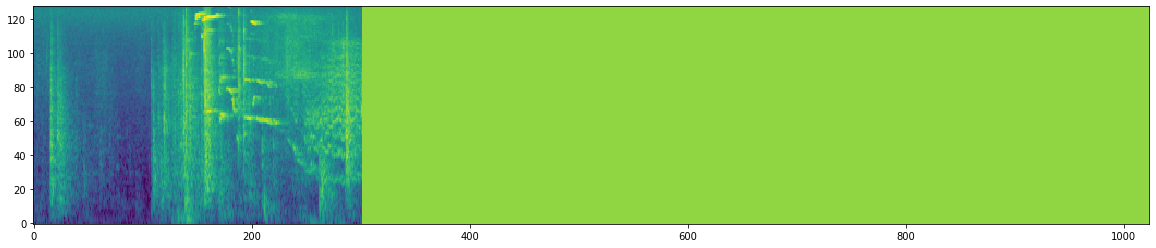

In [13]:
fbank = wav2fbank(wav_file)
fbank = norm_fbank(fbank)
display_fbank(fbank)

In [18]:
fbank.shape

torch.Size([1024, 128])

In [17]:
with torch.no_grad():
    embeddings = model(fbank.unsqueeze(0), return_embeddings=True)

print(embeddings.shape)

ValueError: not enough values to unpack (expected 4, got 3)

In [19]:
dataset = AudiosetDataset(None, audio_conf={'num_mel_bins':128}) 

# Preprocess audio 
with torch.no_grad():
  spec = dataset._wav2fbank(waveform)
  spec = (spec - dataset.norm_mean) / dataset.norm_std

TypeError: expected str, bytes or os.PathLike object, not NoneType